<a href="https://colab.research.google.com/github/SebasHur/HUV/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Start 
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import json
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from scipy import stats
import datetime as dt


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


> # <center> *HOSPITAL UNIVERSITARIO DEL VALLE “EVARISTO GARCIA” E.S.E*
# <center>  *RETO TRAUMA*

 


---



**By  :  ARLEY FERNANDO TORRES | JOSE LUIS GOMEZ  | MANUEL ALFREDO FIGUEREDO | SEBASTIAN ESPINOSA | SEBASTIAN HURTADO | SIMON GALEANO**


---

# 1. INTRODUCTION
The University Hospital of Valle must attend a large population of victims of personal injuries; only 7081 in 2012. This population generates a high cost for the health system, so the hospital is interested in knowing this population and its behavior over the last 5 years. It is expected to know the costs that these generate to the health system and to be able to create proposals of programs for the promotion and prevention of violence.

## 1.1 Business Context
___

In the meetings held with the Hospital Universitario del Valle, there are 3 main objectives: 

1. To obtain structured information on trauma patients that will allow us to know their care needs.
2. To establish a baseline of the costs of care that can be monitored as the operation of the service improves.3. To know the AVPP of the patients and the costs for the health system and the productive apparatus of society.

To this end, the hospital must provide us with additional information, since the information provided so far is not sufficient for this purpose.  The information provided only has the values grouped at the invoice level, but there is no detail of the services actually rendered. For this purpose, the institution must provide us with Supplies database,Drug database, Socioeconomic information and Medical History Information. For the moment, this is an advance in the EDA of the initially shared source, but we should delve into the other sources that the hospital provides us with. The following are the preliminary results of EDA. 

#   **2. DATA SOURCE**

---


In [ ]:
data1_unique = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/facturas_unicas.csv',index_col=0)

FileNotFoundError: ignored

First we will clean the database taking into account that when a person is independent this is registered in the EPS fields with the same data of the patient, likewise given the 5 years of study, the EPS with less than 100 patients treated are cleaned and classified as independent, this because having so few occurrences they do not have a cost agreement with the hospital. 

In [ ]:
data1_unique.loc[data1_unique['codigo responsable'] == data1_unique['numero de identificacion del paciente'], 'responsable EPS'] = 'independiente'
data1_unique.loc[data1_unique['codigo responsable'] == data1_unique['numero de identificacion del paciente'], 'codigo responsable'] = '000'
count_freq =dict(data1_unique['responsable EPS'].value_counts())
data1_unique['count_freq'] = data1_unique['responsable EPS']
data1_unique['count_freq'] = data1_unique['count_freq'].map(count_freq)
data1_unique.loc[data1_unique['count_freq'] < 100,'responsable EPS'] = 'independiente'
data1_unique.loc[data1_unique['count_freq'] < 100,'codigo responsable'] = '000'

In [ ]:
data1_unique['responsable EPS'].nunique()

33

In [ ]:
data1_unique.isnull().sum()

fuente_evento                                          0
Fuente Facturacion                                     0
Numero factura fiscal                                  0
año factura fiscal                                     0
mes factura fiscal                                     0
historia clinica  PK                                   0
secuencia ingreso PK                                   0
nombre paciente                                       56
codigo responsable                                     0
responsable EPS                                        0
valor factura fiscal                                   0
concepto facturacion asociado al servicio venta        0
CUPs - Actividad                                       0
centro de costo                                        0
nombre cups - actividad                                0
tipo POS                                               3
codigo sala clinica egreso                             0
nombre sala clinica egreso     

In [ ]:
for col in data1_unique.columns:
    print(f"{col}\t has\t:\t {data1_unique[col].nunique()} \t, Unique Values")

fuente_evento	 has	:	 1 	, Unique Values
Fuente Facturacion	 has	:	 4 	, Unique Values
Numero factura fiscal	 has	:	 38656 	, Unique Values
año factura fiscal	 has	:	 5 	, Unique Values
mes factura fiscal	 has	:	 12 	, Unique Values
historia clinica  PK	 has	:	 33166 	, Unique Values
secuencia ingreso PK	 has	:	 28 	, Unique Values
nombre paciente	 has	:	 33174 	, Unique Values
codigo responsable	 has	:	 70 	, Unique Values
responsable EPS	 has	:	 33 	, Unique Values
valor factura fiscal	 has	:	 32819 	, Unique Values
concepto facturacion asociado al servicio venta	 has	:	 28 	, Unique Values
CUPs - Actividad	 has	:	 1569 	, Unique Values
centro de costo	 has	:	 92 	, Unique Values
nombre cups - actividad	 has	:	 1538 	, Unique Values
tipo POS	 has	:	 3 	, Unique Values
codigo sala clinica egreso	 has	:	 69 	, Unique Values
nombre sala clinica egreso	 has	:	 69 	, Unique Values
fecha actividad	 has	:	 1824 	, Unique Values
fecha ingreso	 has	:	 1834 	, Unique Values
fecha egreso	 has	:

# MACHINE LEARNING MODELS
---

First model: we will look for a model that can predict the cost of the patient according to the data that enter the hospital.

### PREDICT: INVOICE VALUE
---

First, we inquire about the data to be taken into account for the prediction. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


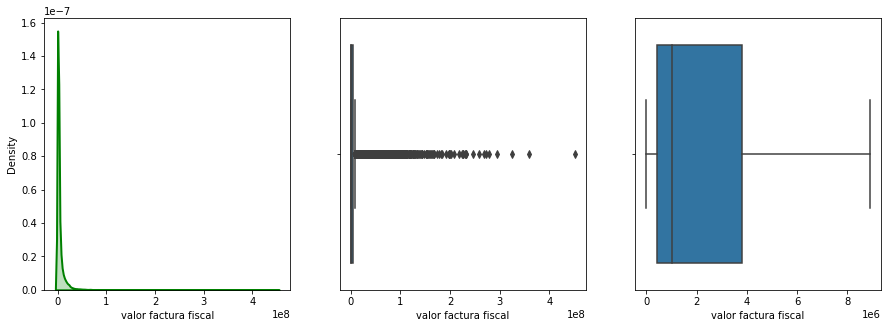

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
 
# plotting the y data 
sns.distplot(data1_unique['valor factura fiscal'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0]);
sns.boxplot(x=data1_unique['valor factura fiscal'], ax = ax[1]);
sns.boxplot(x=data1_unique['valor factura fiscal'], ax = ax[2], showfliers = False);

We continue with 2 models, one where we include the outliers and the other where we omit them.

In [ ]:
data_clean_out = data1_unique.copy()
cols = ['valor factura fiscal'] 

Q1 = data_clean_out[cols].quantile(0.25)
Q3 = data_clean_out[cols].quantile(0.75)
IQR = Q3 - Q1

data_clean_out = data_clean_out[~((data_clean_out[cols] < (Q1 - 1.5 * IQR)) |(data_clean_out[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(data1_unique.shape)
print(data_clean_out.shape)


(38656, 37)
(33675, 37)


In [ ]:
data1_unique['valor factura fiscal'].describe()

count    3.865600e+04
mean     4.735326e+06
std      1.263463e+07
min      4.636700e+02
25%      4.141750e+05
50%      1.040562e+06
75%      3.809550e+06
max      4.505262e+08
Name: valor factura fiscal, dtype: float64

In [ ]:
data_clean_out['valor factura fiscal'].describe()

count    3.367500e+04
mean     1.656186e+06
std      1.968969e+06
min      4.636700e+02
25%      3.557065e+05
50%      8.162000e+05
75%      2.109387e+06
max      8.899088e+06
Name: valor factura fiscal, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


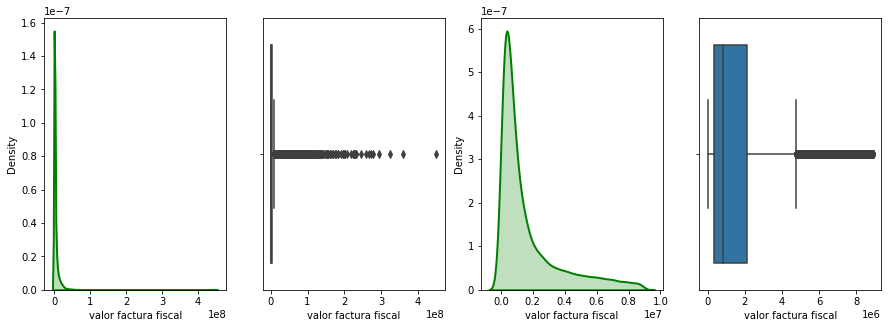

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15,5))
 
# plotting the y data 
sns.distplot(data1_unique['valor factura fiscal'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.boxplot(x=data1_unique['valor factura fiscal'], ax = ax[1])
sns.distplot(data_clean_out['valor factura fiscal'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[2])
sns.boxplot(x=data_clean_out['valor factura fiscal'], ax = ax[3])

## Entry Model Data and Predictor


We choose the data entry data, when a patient arrives at the clinic we will know:

* date of birth
*   Entry Diagnose
*   Gender
* EPS
* POS Type

The other data are data that will be collected throughout the patient's time in the clinic, so they will not be used since they are data obtained in the future. 

We also perform box-cox transformation for the invoice value in order to normalize its distribution. 

In [ ]:
data1_unique.shape

(38656, 37)

In [ ]:
data1_unique[['valor factura fiscal', 'responsable EPS','genero - sexo','Fecha de nacimiento','cie10 egrdin','tipo POS']].isnull().sum()


valor factura fiscal    0
responsable EPS         0
genero - sexo           0
Fecha de nacimiento     0
cie10 egrdin            0
tipo POS                3
dtype: int64

In [ ]:
data1_unique = data1_unique.dropna(subset = ['tipo POS'])
data1_unique.shape

(38653, 37)

In [ ]:

#data complete
data = data1_unique[['valor factura fiscal', 'responsable EPS','genero - sexo','Fecha de nacimiento','cie10 egrdin','tipo POS']]
data = pd.get_dummies(data,columns=['responsable EPS', 'genero - sexo', 'cie10 egrdin','tipo POS'], drop_first=True)
data['Fecha de nacimiento'] = pd.to_datetime(data['Fecha de nacimiento'])
data['Fecha de nacimiento']=data['Fecha de nacimiento'].map(dt.datetime.toordinal)
transformed_cost, lambda_cost = stats.boxcox(data['valor factura fiscal'])
data['valor_cox'] = transformed_cost
f_train, f_test = train_test_split(data, test_size = .3, random_state = 42)

#data sin outliers
data_out = data_clean_out[['valor factura fiscal', 'responsable EPS','genero - sexo','Fecha de nacimiento','cie10 egrdin', 'tipo POS']]
data_out = pd.get_dummies(data_out,columns=['responsable EPS', 'genero - sexo', 'cie10 egrdin','tipo POS'], drop_first=True)
data_out['Fecha de nacimiento'] = pd.to_datetime(data_out['Fecha de nacimiento'])
data_out['Fecha de nacimiento']=data_out['Fecha de nacimiento'].map(dt.datetime.toordinal)
transformed_cost_out, lambda_cost_out = stats.boxcox(data_out['valor factura fiscal'])
data_out['valor_cox'] = transformed_cost_out
f_train_out, f_test_out = train_test_split(data_out, test_size = .3, random_state = 42)

print(f_train.shape)
print(f_test.shape)
print(f_train_out.shape)
print(f_test_out.shape)

(27057, 1401)
(11596, 1401)
(23572, 1303)
(10103, 1303)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

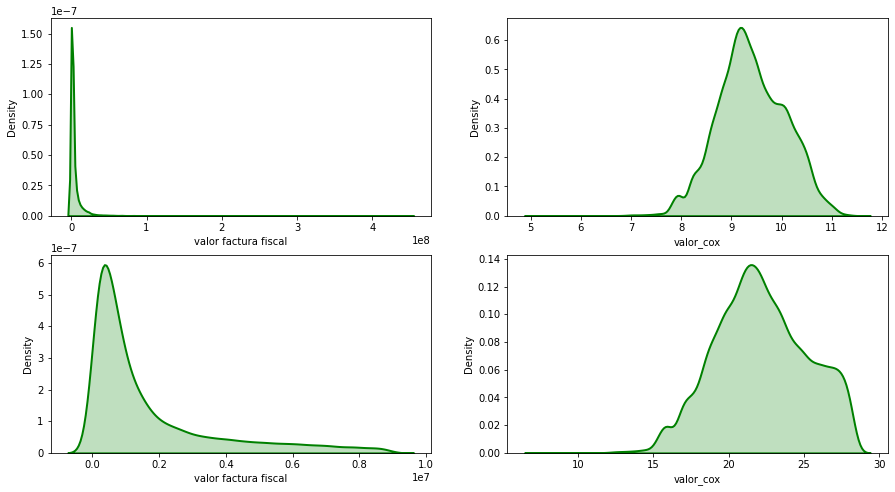

In [ ]:
fig, ax = plt.subplots(2, 2,figsize=(15,8))
 
# plotting the original data and
# fitted data 
sns.distplot(data['valor factura fiscal'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0,0]);
 
sns.distplot(data['valor_cox'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[0,1]);

sns.distplot(data_out['valor factura fiscal'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[1,0]);
 
sns.distplot(data_out['valor_cox'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1,1]);
sns.set(font_scale=1, rc={'figure.facecolor':'EBF2EE'})

 

We create a partition in the data for training and testing. 

In [ ]:
def prediction(df,df2,column_pred):
  X_train = df.drop(columns = ['valor factura fiscal','valor_cox'], axis = 1)
  y_train = df[column_pred]
  X_test= df2.drop(columns = ['valor factura fiscal','valor_cox'], axis = 1)
  y_test = df2[column_pred]
  return X_train, y_train, X_test, y_test


# test['reverse'] = np.exp(np.log(lambda_cost*f_train['valor_cox']+1)/lambda_cost)


In [ ]:
def plot_results(y_train_pred,y_test_pred,y_train,y_test):
  results_train = pd.DataFrame({'predict': y_train_pred,'real': y_train,'set' : 'train'})
  results_test = pd.DataFrame({'predict': y_test_pred,'real': y_test,'set' : 'test'})
  results = pd.concat([results_train ,results_test])
  results['errors'] = results['real']- results['predict']
  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,8))
  sns.scatterplot(data=results ,x = 'real', y ='predict', hue='set', ax = axes[0])
  sns.histplot(data = results, x='errors', ax = axes[1], bins = 100, hue='set')
  # ax[0].yscale('log')
  # ax[0].xscale('log')
  p1 = max(max(results['predict']), max(results['real']))
  p2 = min(min(results['predict']), min(results['real']))
  axes[0].plot([p1, p2], [p1, p2], 'b-')
  axes[0].set(xlabel='True Values',ylabel='Predictions')#,xscale='log',yscale='log')
  axes[1].set(xlabel='ERROR',ylabel='density')#,xscale='log',yscale='log')
  fig.tight_layout()
  return 


In [ ]:
def regresion_lineal(X_train, y_train, X_test, y_test):
  reg_lineal = LinearRegression()
  reg_lineal.fit(X_train, y_train)
  cv_results = cross_validate(reg_lineal, X_train, y_train, cv = 5, scoring="neg_root_mean_squared_error")
  y_pred_train = reg_lineal.predict(X_train)
  y_pred_test = reg_lineal.predict(X_test)
  return y_pred_train, y_pred_test


# LINEAR REGRESION (ALL THE DATA)

Error de train: 11579954.972453628
Error de test: 13479475.589124246
R2 score: 0.01950080767386997


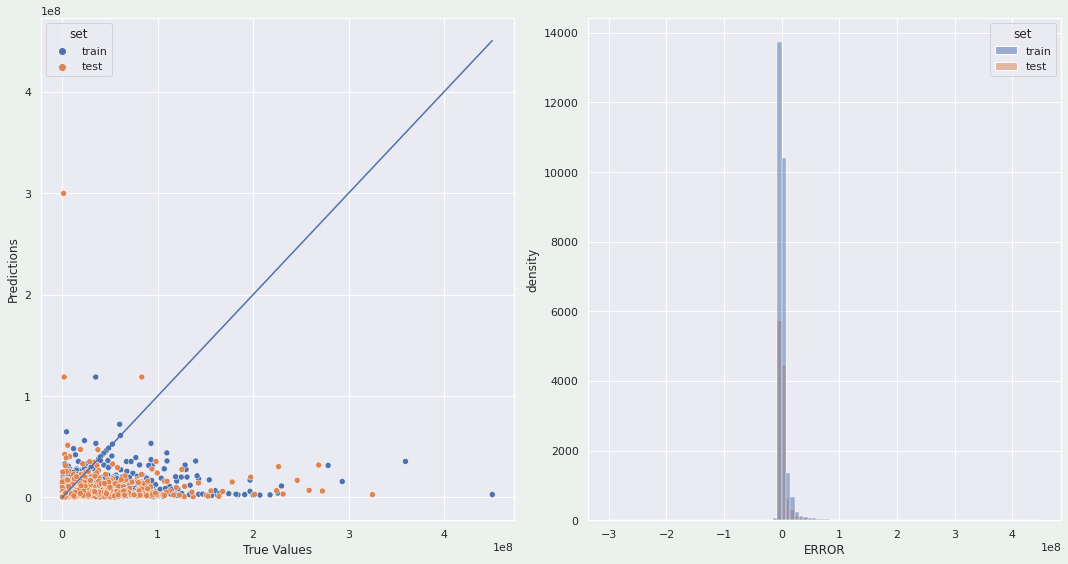

In [ ]:
X_train, y_train, X_test, y_test = prediction(f_train,f_test, 'valor_cox')
y_pred_train_reglineal, y_pred_test_reglineal = regresion_lineal(X_train, y_train, X_test, y_test)

y_pred_test_reglineal = np.exp(np.log(lambda_cost*y_pred_test_reglineal+1)/lambda_cost)
y_pred_train_reglineal = np.exp(np.log(lambda_cost*y_pred_train_reglineal+1)/lambda_cost)
y_train = np.exp(np.log(lambda_cost*y_train+1)/lambda_cost)
y_test = np.exp(np.log(lambda_cost*y_test+1)/lambda_cost)

plot_results(y_pred_train_reglineal,y_pred_test_reglineal, y_train, y_test)
rmse_train = mean_squared_error(y_train, y_pred_train_reglineal, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test_reglineal, squared=False)
print(f"Error de train: {rmse_train}\nError de test: {rmse_test}")
print("R2 score:", r2_score(y_test,y_pred_test_reglineal, multioutput='variance_weighted'))

# LINEAR REGRESSION WITHOUT OUTLIERS IN INVOICES

Error de train: 2.4976175552592257
Error de test: 8180459.293004919


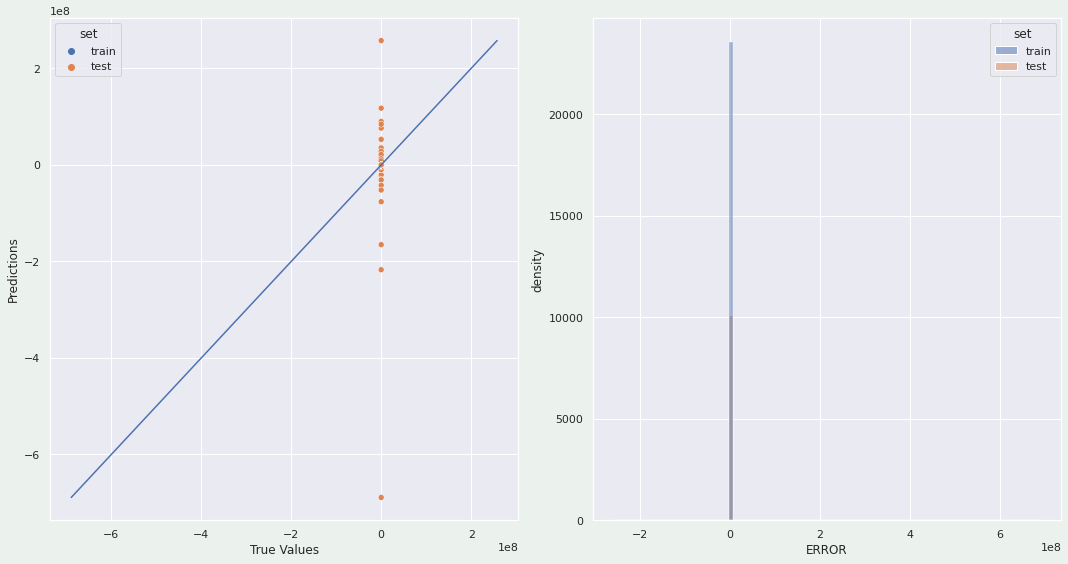

In [ ]:
X_train_out, y_train_out, X_test_out, y_test_out = prediction(f_train_out, f_test_out, 'valor_cox')
y_pred_train_reglineal_out, y_pred_test_reglineal_out = regresion_lineal(X_train_out, y_train_out, X_test_out, y_test)

plot_results(y_pred_train_reglineal_out, y_pred_test_reglineal_out, y_train_out, y_test_out)
rmse_train_out = mean_squared_error(y_train_out, y_pred_train_reglineal_out, squared=False)
rmse_test_out = mean_squared_error(y_test_out, y_pred_test_reglineal_out, squared=False)
print(f"Error de train: {rmse_train_out}\nError de test: {rmse_test_out}")

In [ ]:
print(f"Error de train: {rmse_train}\nError de test: {rmse_test}")
print(f"Error de train no outliers: {rmse_train_out}\nError de test no outliers: {rmse_test_out}")

Error de train: 0.5258467489776186
Error de test: 0.5527034335530286
Error de train no outliers: 2.4976175552592257
Error de test no outliers: 8180459.293004919


Se realiza el mismo proceso con los datos limpios de outliers:

##XGBOOST

In [ ]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
f_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in f_train.columns.values]
f_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in f_test.columns.values]
f_train_out.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in f_train_out.columns.values]
f_test_out.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in f_test_out.columns.values]

#WITH OUTLIERS

[15:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.28034e+07	validation_1-rmse:1.42766e+07
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.26246e+07	validation_1-rmse:1.41011e+07
[2]	validation_0-rmse:1.24585e+07	validation_1-rmse:1.3936e+07
[3]	validation_0-rmse:1.23334e+07	validation_1-rmse:1.38092e+07
[4]	validation_0-rmse:1.22213e+07	validation_1-rmse:1.37e+07
[5]	validation_0-rmse:1.21314e+07	validation_1-rmse:1.36072e+07
[6]	validation_0-rmse:1.20507e+07	validation_1-rmse:1.3525e+07
[7]	validation_0-rmse:1.19827e+07	validation_1-rmse:1.3459e+07
[8]	validation_0-rmse:1.19251e+07	validation_1-rmse:1.341e+07
[9]	validation_0-rmse:1.18564e+07	validation_1-rmse:1.33456e+07
[10]	validation_0-rmse:1.18113e+07	validation_1-rmse:1.3299e+07
[11]	validation_0-

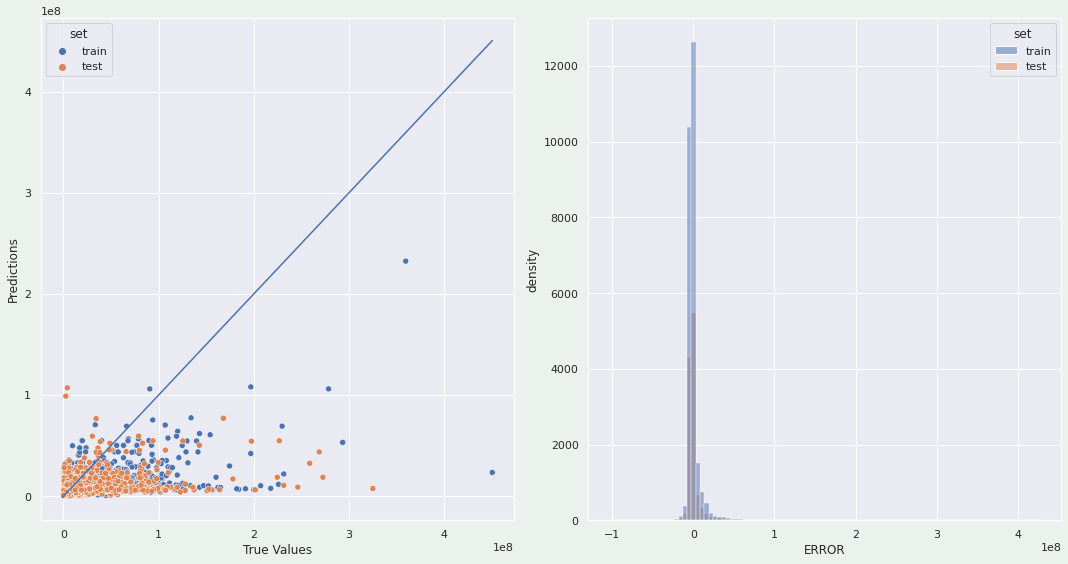

In [ ]:
X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb = prediction(f_train, f_test, 'valor factura fiscal')

xgb1 = XGBRegressor(n_estimators = 10000)
eval_set = [(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)]
xgb1.fit(X_train_xgb, y_train_xgb, eval_metric="rmse", early_stopping_rounds=10, eval_set=eval_set, verbose=True)
y_test_pred_xgb = xgb1.predict(X_test_xgb)
y_train_pred_xgb = xgb1.predict(X_train_xgb)

plot_results(y_train_pred_xgb, y_test_pred_xgb, y_train_xgb, y_test_xgb)
rmse_train_xgb1 = mean_squared_error(y_train_xgb, y_train_pred_xgb, squared=False)
rmse_test_xgb1 = mean_squared_error(y_test_xgb, y_test_pred_xgb, squared=False)
print(f"Error de train: {rmse_train_xgb1}\nError de test: {rmse_test_xgb1}")


#WITHOUT OUTLIERS

[15:36:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.45526e+06	validation_1-rmse:2.45837e+06
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.35637e+06	validation_1-rmse:2.35995e+06
[2]	validation_0-rmse:2.27307e+06	validation_1-rmse:2.27687e+06
[3]	validation_0-rmse:2.20323e+06	validation_1-rmse:2.20743e+06
[4]	validation_0-rmse:2.14519e+06	validation_1-rmse:2.15068e+06
[5]	validation_0-rmse:2.09679e+06	validation_1-rmse:2.10316e+06
[6]	validation_0-rmse:2.05652e+06	validation_1-rmse:2.06292e+06
[7]	validation_0-rmse:2.02236e+06	validation_1-rmse:2.02894e+06
[8]	validation_0-rmse:1.99341e+06	validation_1-rmse:2.00018e+06
[9]	validation_0-rmse:1.96997e+06	validation_1-rmse:1.97735e+06
[10]	validation_0-rmse:1.9506e+06	validation_1-rmse:1.95833e+06
[11]	valid

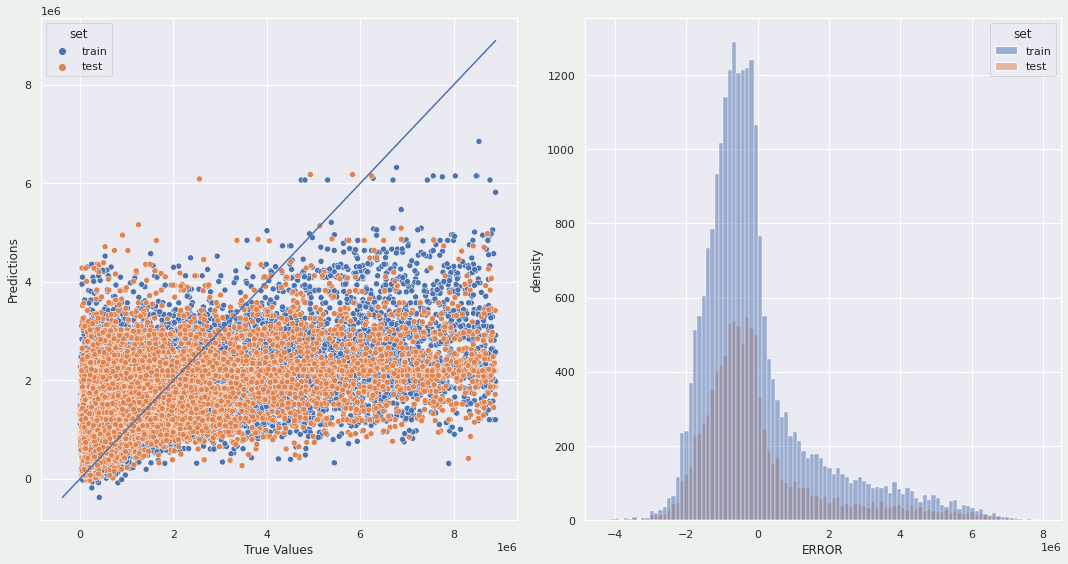

In [ ]:
X_train_xgb_out, y_train_xgb_out, X_test_xgb_out, y_test_xgb_out = prediction(f_train_out, f_test_out, 'valor factura fiscal')

xgb2 = XGBRegressor(n_estimators = 10000)
eval_set = [(X_train_xgb_out, y_train_xgb_out), (X_test_xgb_out, y_test_xgb_out)]
xgb2.fit(X_train_xgb_out, y_train_xgb_out, eval_metric="rmse", early_stopping_rounds=10, eval_set=eval_set, verbose=True)
y_test_pred_xgb_out = xgb2.predict(X_test_xgb_out)
y_train_pred_xgb_out = xgb2.predict(X_train_xgb_out)

plot_results(y_train_pred_xgb_out, y_test_pred_xgb_out, y_train_xgb_out, y_test_xgb_out)
rmse_train_xgb_out2 = mean_squared_error(y_train_xgb_out, y_train_pred_xgb_out, squared=False)
rmse_test_xgb_out2 = mean_squared_error(y_test_xgb_out, y_test_pred_xgb_out, squared=False)
print(f"Error de train: {rmse_train_xgb_out2}\nError de test: {rmse_test_xgb_out2}")

[15:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.02886	validation_1-rmse:8.04359
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.23121	validation_1-rmse:7.24639
[2]	validation_0-rmse:6.51388	validation_1-rmse:6.52924
[3]	validation_0-rmse:5.86884	validation_1-rmse:5.88456
[4]	validation_0-rmse:5.28899	validation_1-rmse:5.30483
[5]	validation_0-rmse:4.76784	validation_1-rmse:4.78393
[6]	validation_0-rmse:4.2996	validation_1-rmse:4.31589
[7]	validation_0-rmse:3.87906	validation_1-rmse:3.89547
[8]	validation_0-rmse:3.50155	validation_1-rmse:3.51804
[9]	validation_0-rmse:3.16286	validation_1-rmse:3.17942
[10]	validation_0-rmse:2.8592	validation_1-rmse:2.87587
[11]	validation_0-rmse:2.5872	validation_1-rmse:2.6038
[12]	validation_0-rmse:2.34376	validation_1-

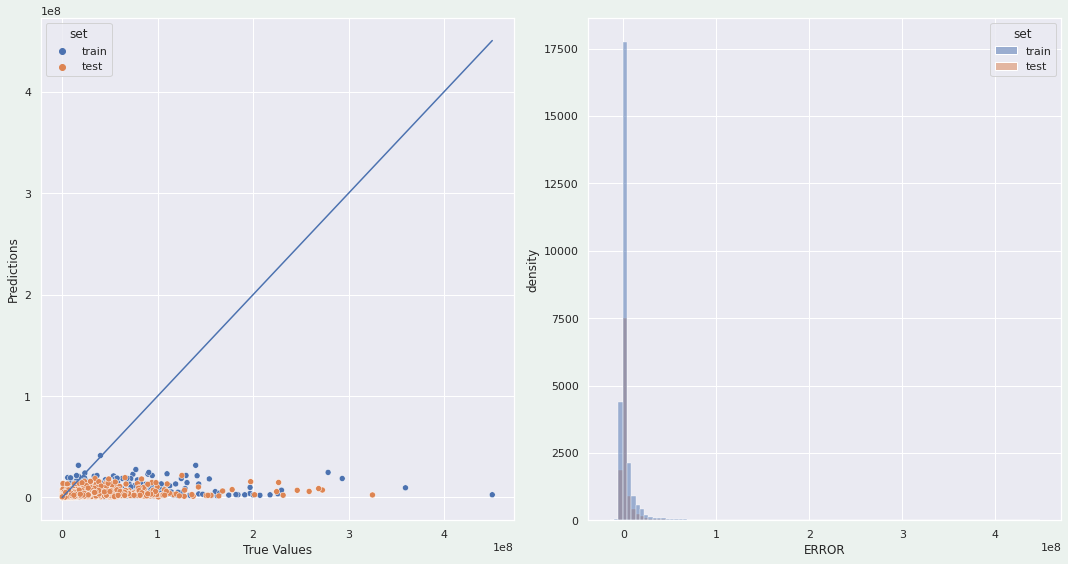

In [ ]:
X_train_xgb1, y_train_xgb1, X_test_xgb1, y_test_xgb1 = prediction(f_train, f_test, 'valor_cox')

xgb3 = XGBRegressor(n_estimators = 10000)
eval_set = [(X_train_xgb1, y_train_xgb1), (X_test_xgb1, y_test_xgb1)]
xgb3.fit(X_train_xgb1, y_train_xgb1, eval_metric="rmse", early_stopping_rounds=10, eval_set=eval_set, verbose=True)
y_test_pred_xgb1 = xgb3.predict(X_test_xgb1)
y_train_pred_xgb1 = xgb3.predict(X_train_xgb1)

y_test_pred_xgb1t = np.exp(np.log(lambda_cost*y_test_pred_xgb1+1)/lambda_cost)
y_train_pred_xgb1t = np.exp(np.log(lambda_cost*y_train_pred_xgb1+1)/lambda_cost)
y_train_xgb1t = np.exp(np.log(lambda_cost*y_train_xgb1+1)/lambda_cost)
y_test_xgb1t = np.exp(np.log(lambda_cost*y_test_xgb1+1)/lambda_cost)

plot_results(y_train_pred_xgb1t, y_test_pred_xgb1t, y_train_xgb1t, y_test_xgb1t)
rmse_train_xgb3 = mean_squared_error(y_train_xgb1t, y_train_pred_xgb1t, squared=False)
rmse_test_xgb3 = mean_squared_error(y_test_xgb1t, y_test_pred_xgb1t, squared=False)
print(f"Error de train: {rmse_train_xgb3}\nError de test: {rmse_test_xgb3}")

[15:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:19.7033	validation_1-rmse:19.736
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:17.7779	validation_1-rmse:17.8108
[2]	validation_0-rmse:16.0496	validation_1-rmse:16.0822
[3]	validation_0-rmse:14.4992	validation_1-rmse:14.5314
[4]	validation_0-rmse:13.1095	validation_1-rmse:13.1418
[5]	validation_0-rmse:11.865	validation_1-rmse:11.8965
[6]	validation_0-rmse:10.7515	validation_1-rmse:10.7823
[7]	validation_0-rmse:9.75677	validation_1-rmse:9.78713
[8]	validation_0-rmse:8.86941	validation_1-rmse:8.8986
[9]	validation_0-rmse:8.0786	validation_1-rmse:8.10704
[10]	validation_0-rmse:7.37604	validation_1-rmse:7.4034
[11]	validation_0-rmse:6.75261	validation_1-rmse:6.77947
[12]	validation_0-rmse:6.20181	validation_1-r

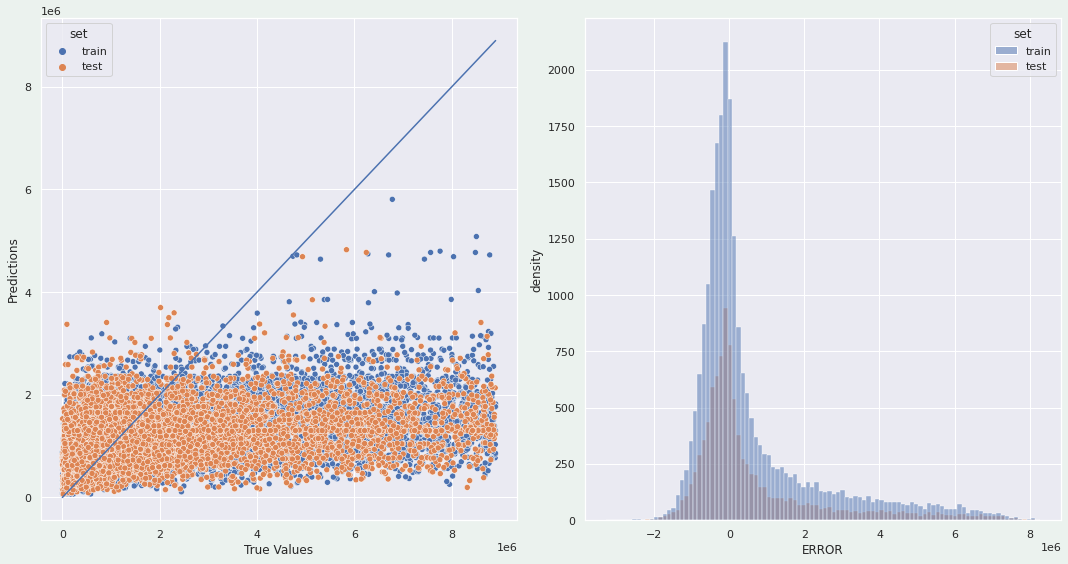

In [ ]:
X_train_xgb_out1, y_train_xgb_out1, X_test_xgb_out1, y_test_xgb_out1 = prediction(f_train_out, f_test_out, 'valor_cox')

xgb4 = XGBRegressor(n_estimators = 10000)
eval_set1 = [(X_train_xgb_out1, y_train_xgb_out1), (X_test_xgb_out1, y_test_xgb_out1)]
xgb4.fit(X_train_xgb_out1, y_train_xgb_out1, eval_metric="rmse", early_stopping_rounds=10, eval_set=eval_set1, verbose=True)

y_test_pred_xgb_out1 = xgb4.predict(X_test_xgb_out1)
y_train_pred_xgb_out1 = xgb4.predict(X_train_xgb_out1)

y_test_pred_xgb_out1t = np.exp(np.log(lambda_cost_out*y_test_pred_xgb_out1+1)/lambda_cost_out)
y_train_pred_xgb_out1t = np.exp(np.log(lambda_cost_out*y_train_pred_xgb_out1+1)/lambda_cost_out)
y_train_xgb_out1t = np.exp(np.log(lambda_cost_out*y_train_xgb_out1+1)/lambda_cost_out)
y_test_xgb_out1t = np.exp(np.log(lambda_cost_out*y_test_xgb_out1+1)/lambda_cost_out)


plot_results(y_train_pred_xgb_out1t, y_test_pred_xgb_out1t, y_train_xgb_out1t, y_test_xgb_out1t)
rmse_train_xgb_out1t = mean_squared_error(y_train_xgb_out1t, y_train_pred_xgb_out1t, squared=False)
rmse_test_xgb_out1t = mean_squared_error(y_test_xgb_out1t, y_test_pred_xgb_out1t, squared=False)
print(f"Error de train: {rmse_train_xgb_out1t}\nError de test: {rmse_test_xgb_out1t}")

In [ ]:
print(f"Xg1 Model\nError de train: {rmse_train_xgb1}\nError de test: {rmse_test_xgb1}")
print(f"Xg2 Model\nError de train: {rmse_train_xgb_out2}\nError de test: {rmse_test_xgb_out2}")
print(f"Xg3 Model\nError de train: {rmse_train_xgb3}\nError de test: {rmse_test_xgb3}")
print(f"Xg4 Model\nError de train: {rmse_train_xgb_out1t}\nError de test: {rmse_test_xgb_out1t}")

Xg1 Model
Error de train: 10486301.4219693
Error de test: 12446887.534438495
Xg2 Model
Error de train: 1683766.1582197875
Error de test: 1764958.354322987
Xg3 Model
Error de train: 11949137.055523511
Error de test: 13486766.722675541
Xg4 Model
Error de train: 1870512.5770872452
Error de test: 1924620.9589549818


#Model Selected
---

We will continue with the best performing model, XGBoost, eliminating outliers.  Now we will see if it improves if a logarithmic transformation is performed on the variables. 
1. Transformation on the variable to be predicted.
2. transformation on date of birth.


[16:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.8815	validation_1-rmse:11.8958
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:10.7061	validation_1-rmse:10.7205
[2]	validation_0-rmse:9.64956	validation_1-rmse:9.66402
[3]	validation_0-rmse:8.70007	validation_1-rmse:8.71442
[4]	validation_0-rmse:7.84717	validation_1-rmse:7.86163
[5]	validation_0-rmse:7.08132	validation_1-rmse:7.09553
[6]	validation_0-rmse:6.39398	validation_1-rmse:6.40819
[7]	validation_0-rmse:5.77759	validation_1-rmse:5.79179
[8]	validation_0-rmse:5.22495	validation_1-rmse:5.23887
[9]	validation_0-rmse:4.73018	validation_1-rmse:4.74417
[10]	validation_0-rmse:4.28765	validation_1-rmse:4.30132
[11]	validation_0-rmse:3.89248	validation_1-rmse:3.90578
[12]	validation_0-rmse:3.54	validation_1

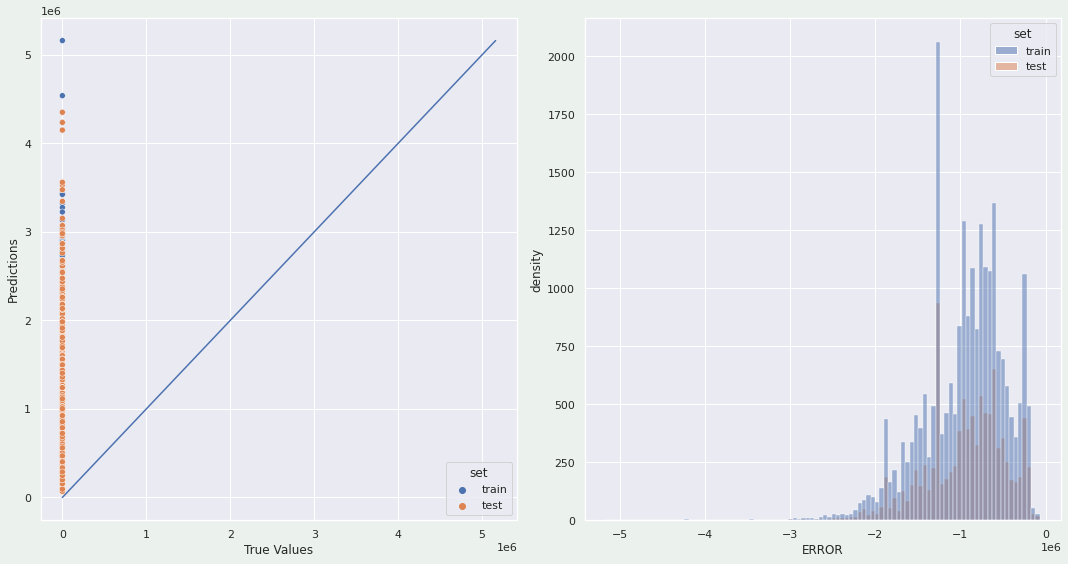

In [ ]:
## Log Y

X_train_xgb_out, y_train_xgb_out, X_test_xgb_out, y_test_xgb_out = prediction(f_train_out, f_test_out, 'valor factura fiscal')

y_train_xgb_out = np.log(y_train_xgb_out)
y_test_xgb_out = np.log(y_test_xgb_out)

xgb2a = XGBRegressor(n_estimators = 10000)
eval_set = [(X_train_xgb_out, y_train_xgb_out), (X_test_xgb_out, y_test_xgb_out)]
xgb2a.fit(X_train_xgb_out, y_train_xgb_out, eval_metric="rmse", early_stopping_rounds=10, eval_set=eval_set, verbose=True)
y_test_pred_xgb_out = xgb2a.predict(X_test_xgb_out)
y_train_pred_xgb_out = xgb2a.predict(X_train_xgb_out)
y_test_pred_xgb_out = np.exp(y_test_pred_xgb_out)
y_train_pred_xgb_out = np.exp(y_train_pred_xgb_out)


plot_results(y_train_pred_xgb_out, y_test_pred_xgb_out, y_train_xgb_out, y_test_xgb_out)
rmse_train_xgb_out2 = mean_squared_error(y_train_xgb_out, y_train_pred_xgb_out, squared=False)
rmse_test_xgb_out2 = mean_squared_error(y_test_xgb_out, y_test_pred_xgb_out, squared=False)
print(f"Error de train: {rmse_train_xgb_out2}\nError de test: {rmse_test_xgb_out2}")

[16:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.45526e+06	validation_1-rmse:2.45837e+06
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.35638e+06	validation_1-rmse:2.35995e+06
[2]	validation_0-rmse:2.27308e+06	validation_1-rmse:2.27687e+06
[3]	validation_0-rmse:2.20324e+06	validation_1-rmse:2.20744e+06
[4]	validation_0-rmse:2.14521e+06	validation_1-rmse:2.15068e+06
[5]	validation_0-rmse:2.09682e+06	validation_1-rmse:2.10316e+06
[6]	validation_0-rmse:2.05654e+06	validation_1-rmse:2.06293e+06
[7]	validation_0-rmse:2.02238e+06	validation_1-rmse:2.02895e+06
[8]	validation_0-rmse:1.99343e+06	validation_1-rmse:2.00018e+06
[9]	validation_0-rmse:1.96999e+06	validation_1-rmse:1.97735e+06
[10]	validation_0-rmse:1.95062e+06	validation_1-rmse:1.95833e+06
[11]	vali

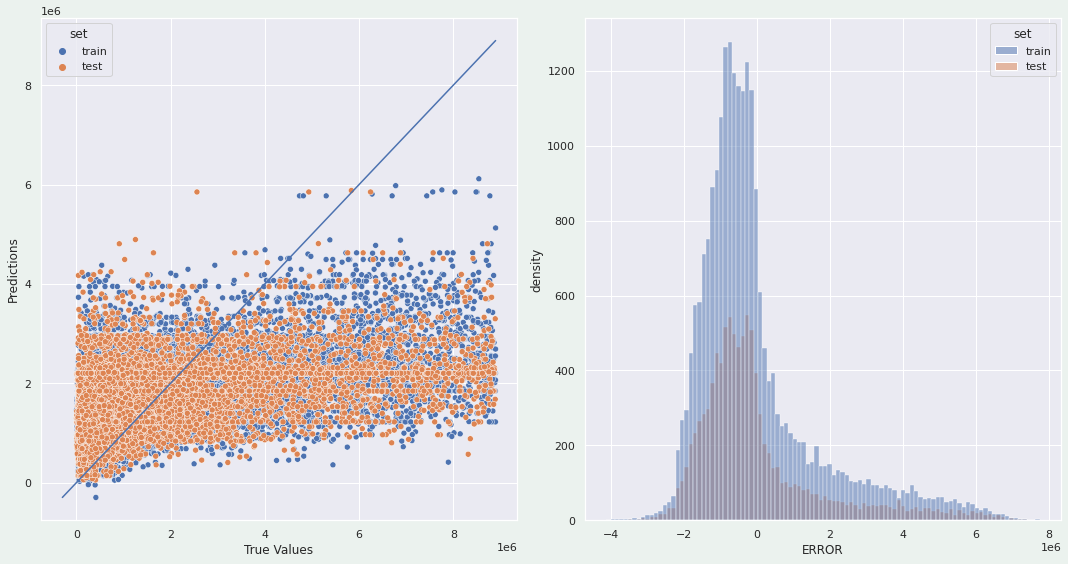

In [ ]:
## Log 'fecha de naciemiento'

X_train_xgb_out, y_train_xgb_out, X_test_xgb_out, y_test_xgb_out = prediction(f_train_out, f_test_out, 'valor factura fiscal')

X_train_xgb_out['Fecha de nacimiento'] = np.log(X_train_xgb_out['Fecha de nacimiento'])
X_test_xgb_out['Fecha de nacimiento'] = np.log(X_test_xgb_out['Fecha de nacimiento'])

xgb2b = XGBRegressor(n_estimators = 10000)
eval_set = [(X_train_xgb_out, y_train_xgb_out), (X_test_xgb_out, y_test_xgb_out)]
xgb2b.fit(X_train_xgb_out, y_train_xgb_out, eval_metric="rmse", early_stopping_rounds=10, eval_set=eval_set, verbose=True)
y_test_pred_xgb_out = xgb2b.predict(X_test_xgb_out)
y_train_pred_xgb_out = xgb2b.predict(X_train_xgb_out)


plot_results(y_train_pred_xgb_out, y_test_pred_xgb_out, y_train_xgb_out, y_test_xgb_out)
rmse_train_xgb_out2b = mean_squared_error(y_train_xgb_out, y_train_pred_xgb_out, squared=False)
rmse_test_xgb_out2b = mean_squared_error(y_test_xgb_out, y_test_pred_xgb_out, squared=False)
print(f"Error de train: {rmse_train_xgb_out2b}\nError de test: {rmse_test_xgb_out2b}")

## Interactions
---
From the input data we have, we will analyze interactions that may have with other data, since we are talking about people we will see if there is any better perfomance in our model if we create an interaction Birht Date and GENDER.  The other columns by their nature should not have any logical explanation about interactions. 

In [ ]:
X_train_xgb_out['genero - sexo_I']

225005    0
2152      0
4778      0
336084    0
129802    0
         ..
84234     0
17440     0
41239     0
2156      0
74210     0
Name: genero - sexo_I, Length: 23572, dtype: uint8

[16:16:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.45526e+06	validation_1-rmse:2.45837e+06
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.35637e+06	validation_1-rmse:2.35995e+06
[2]	validation_0-rmse:2.27307e+06	validation_1-rmse:2.27687e+06
[3]	validation_0-rmse:2.20323e+06	validation_1-rmse:2.20743e+06
[4]	validation_0-rmse:2.14519e+06	validation_1-rmse:2.15068e+06
[5]	validation_0-rmse:2.09679e+06	validation_1-rmse:2.10303e+06
[6]	validation_0-rmse:2.05621e+06	validation_1-rmse:2.06251e+06
[7]	validation_0-rmse:2.02251e+06	validation_1-rmse:2.02881e+06
[8]	validation_0-rmse:1.99442e+06	validation_1-rmse:2.00153e+06
[9]	validation_0-rmse:1.97101e+06	validation_1-rmse:1.97836e+06
[10]	validation_0-rmse:1.9516e+06	validation_1-rmse:1.95947e+06
[11]	valid

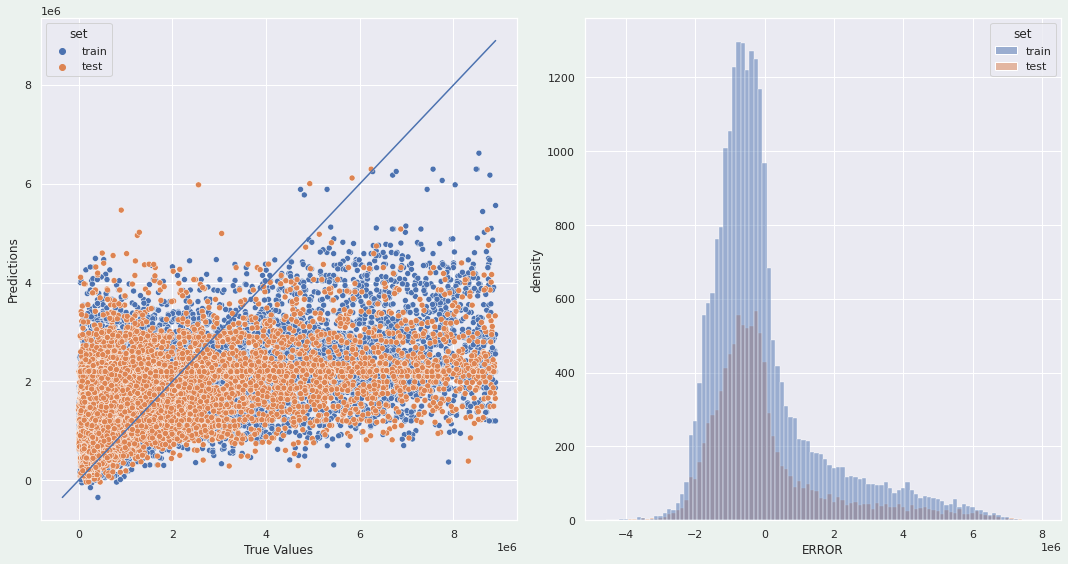

In [ ]:
X_train_xgb_out, y_train_xgb_out, X_test_xgb_out, y_test_xgb_out = prediction(f_train_out, f_test_out, 'valor factura fiscal')

X_train_xgb_out['Interaction_M'] = X_train_xgb_out['Fecha de nacimiento']*X_train_xgb_out['genero - sexo_M']
X_test_xgb_out['Interaction_M'] = X_test_xgb_out['Fecha de nacimiento']*X_test_xgb_out['genero - sexo_M']
X_train_xgb_out['Interaction_I'] = X_train_xgb_out['Fecha de nacimiento']*X_train_xgb_out['genero - sexo_I']
X_test_xgb_out['Interaction_I'] = X_test_xgb_out['Fecha de nacimiento']*X_test_xgb_out['genero - sexo_I']

xgb2i = XGBRegressor(n_estimators = 10000)
eval_set = [(X_train_xgb_out, y_train_xgb_out), (X_test_xgb_out, y_test_xgb_out)]
xgb2i.fit(X_train_xgb_out, y_train_xgb_out, eval_metric="rmse", early_stopping_rounds=10, eval_set=eval_set, verbose=True)
y_test_pred_xgb_out = xgb2i.predict(X_test_xgb_out)
y_train_pred_xgb_out = xgb2i.predict(X_train_xgb_out)


plot_results(y_train_pred_xgb_out, y_test_pred_xgb_out, y_train_xgb_out, y_test_xgb_out)
rmse_train_xgb_out2i = mean_squared_error(y_train_xgb_out, y_train_pred_xgb_out, squared=False)
rmse_test_xgb_out2i = mean_squared_error(y_test_xgb_out, y_test_pred_xgb_out, squared=False)
print(f"Error de train: {rmse_train_xgb_out2i}\nError de test: {rmse_test_xgb_out2i}")

#EXPORT MODEL
---

We have made several approximations to the model and found that it is not possible to obtain an adequate model to make predictions, this is due to the limited input data available. However, we see that an adequate model could be generated if we had more data on the patients at the entrance to the hospital, as these would give indications of their state of health at the time of arrival.  The hospital can continue the path provided by Data Science and will be able to arrive at a model that can predict the costs that a person will have at the time of arrival. 

We will use our best model to demonstrate to the hospital what it would look like if the goal of training a good model is achieved.

Error de train: 1683766.1582197875
Error de test: 1764958.354322987
R2 score: 0.1954787064619784


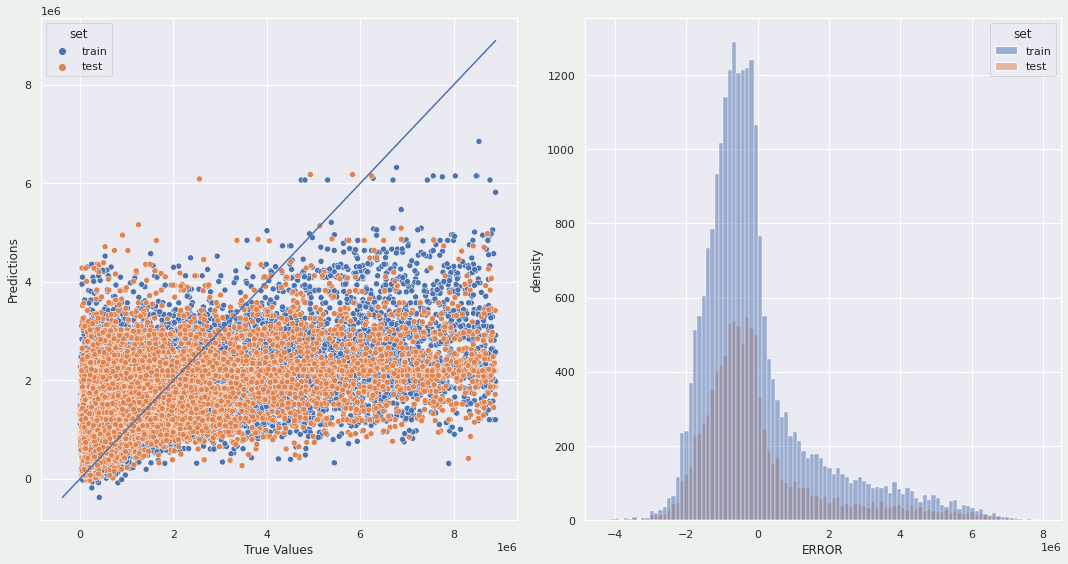

In [ ]:
X_train_xgb_out, y_train_xgb_out, X_test_xgb_out, y_test_xgb_out = prediction(f_train_out, f_test_out, 'valor factura fiscal')

y_test_pred_xgb_out = xgb2.predict(X_test_xgb_out)
y_train_pred_xgb_out = xgb2.predict(X_train_xgb_out)

plot_results(y_train_pred_xgb_out, y_test_pred_xgb_out, y_train_xgb_out, y_test_xgb_out)
rmse_train_xgb_out2 = mean_squared_error(y_train_xgb_out, y_train_pred_xgb_out, squared=False)
rmse_test_xgb_out2 = mean_squared_error(y_test_xgb_out, y_test_pred_xgb_out, squared=False)
print(f"Error de train: {rmse_train_xgb_out2}\nError de test: {rmse_test_xgb_out2}")
print("R2 score:", r2_score(y_test_xgb_out,y_test_pred_xgb_out, multioutput='variance_weighted'))

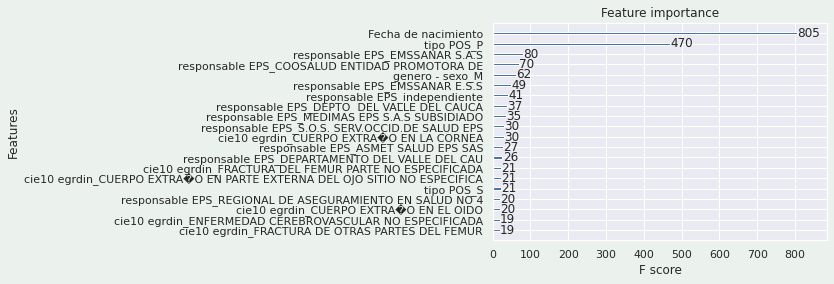

In [ ]:
from xgboost import plot_importance
plot_importance(xgb2, max_num_features=20) # top 20 most important features
plt.show()

In [ ]:
X_train_xgb_out, y_train_xgb_out, X_test_xgb_out, y_test_xgb_out = prediction(f_train_out, f_test_out, 'valor factura fiscal')

xgbg = XGBRegressor()
hyperparameter_grid = {
    'n_estimators': [400, 1000],
    'max_depth': [10,20,30],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

grid_xgb =  GridSearchCV(xgbg, hyperparameter_grid, )

eval_set = [(X_train_xgb_out, y_train_xgb_out), (X_test_xgb_out, y_test_xgb_out)]
grid_xgb.fit(X_train_xgb_out, y_train_xgb_out, eval_metric="rmse", early_stopping_rounds=10, eval_set=eval_set, verbose=False)

y_test_pred_xgb_out = grid_xgb.best_estimator_.predict(X_test_xgb_out)
y_train_pred_xgb_out = grid_xgb.best_estimator_.predict(X_train_xgb_out)

plot_results(y_train_pred_xgb_out, y_test_pred_xgb_out, y_train_xgb_out, y_test_xgb_out)
rmse_train_xgb_grid = mean_squared_error(y_train_xgb_out, y_train_pred_xgb_out, squared=False)
rmse_test_xgb_grid = mean_squared_error(y_test_xgb_out, y_test_pred_xgb_out, squared=False)
print(f"Error de train: {rmse_train_xgb_grid}\nError de test: {rmse_test_xgb_grid}")
print("R2 score:", r2_score(y_test_xgb_out,y_test_pred_xgb_out, multioutput='variance_weighted'))

[17:00:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
grid_xgb.best_estimator_

In [ ]:
import joblib

model_file = open("MODELO_ESCOGIDO.pkl","wb")
joblib.dump(xgb2,model_file)
model_file.close()
model_file = open("MODELO_ESCOGIDO_GRID.pkl","wb")
joblib.dump(grid_xgb.best_estimator_,model_file)
model_file.close()